In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [234]:
class Value:
    def __init__(self, data, child = (), op=''):
        self.data = data
        self._prev = child
        self._op = op
        self.grad = 0.0
        self._backward = lambda: None
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __repr__(self):
        return f"{self.__class__.__name__}(data={self.data})"
    
    def backward(self):
        childs = []
        visited = []
        def unpack(node):
            if node not in visited:
                visited.append(node)
                for child in node._prev:
                    unpack(child)
                childs.append(node)
        unpack(self)
        self.grad = 1.0
        for node in reversed(childs):
            node._backward()
            
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'Relu')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
            
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other):
        return other * self**-1
    
    def __neg__(self):
        return self * -1

In [277]:
class Neuron:
    def __init__(self, inp, nonlin=True):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(inp)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        Z = sum([w*x_ for w, x_ in zip(self.w, x)], self.b)
        return Z.relu() if self.nonlin else Z
    
    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}{self.__class__.__name__}({len(self.w)})"

In [276]:
class Layer:
    def __init__(self, nin, neurons, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(neurons)]
    
    def __call__(self, x):
        return [n(x) for n in self.neurons]
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

In [274]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

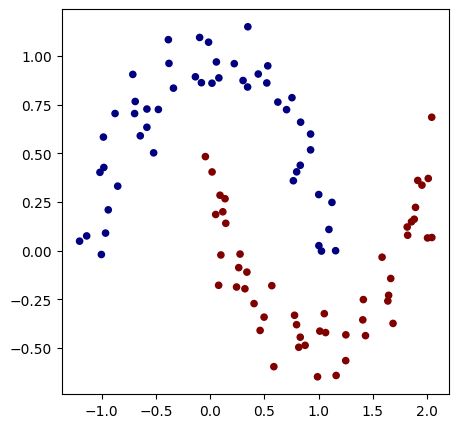

In [295]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [322]:
model = MLP(X.shape[1], [10,10,1])

In [323]:
# loss function
def loss():

    inputs = [list(map(Value, xrow)) for xrow in X]
    
    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei[0]).relu() for yi, scorei in zip(y, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei[0].data > 0) for yi, scorei in zip(y, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.4197804077889034) 0.31


In [324]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    for item in model.parameters():
        item.grad = 0.0
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.4197804077889034, accuracy 31.0%
step 1 loss 0.579064311296106, accuracy 78.0%
step 2 loss 0.7255293697374962, accuracy 75.0%
step 3 loss 0.4511264586014024, accuracy 79.0%
step 4 loss 0.361648082196591, accuracy 82.0%
step 5 loss 0.31882334809792584, accuracy 86.0%
step 6 loss 0.37950540707398783, accuracy 86.0%
step 7 loss 0.30808888311310517, accuracy 88.0%
step 8 loss 0.33882738884067254, accuracy 86.0%
step 9 loss 0.2713556649003337, accuracy 87.0%
step 10 loss 0.28390570722824127, accuracy 87.0%
step 11 loss 0.23505176758542234, accuracy 90.0%
step 12 loss 0.23925243862316592, accuracy 91.0%
step 13 loss 0.25269809292618817, accuracy 87.0%
step 14 loss 0.3206861356058514, accuracy 88.0%
step 15 loss 0.24827891908372576, accuracy 89.0%
step 16 loss 0.24932028887380345, accuracy 89.0%
step 17 loss 0.19895959559080806, accuracy 92.0%
step 18 loss 0.18694477162358983, accuracy 92.0%
step 19 loss 0.1886340210865742, accuracy 93.0%
step 20 loss 0.18795377381489203, accura

(-1.6482441174508837, 2.1017558825491163)

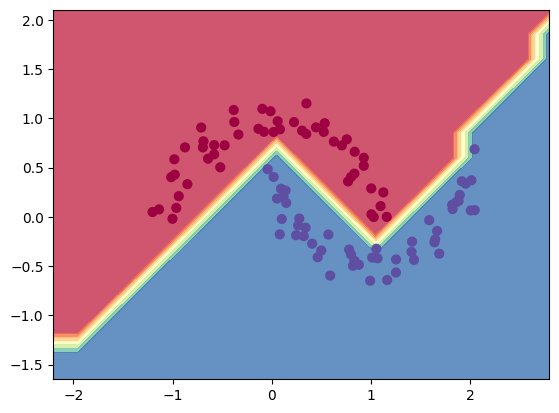

In [327]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s[0].data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())